In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [2]:
import numpy as np

In [3]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Define the grid dimensions and Umbrella Valence you want

In [4]:
degree = 3 # 3 for TriUmbrellas, 4 for QuadUmbrellas, 6 for HexBrellas
rows = 2 #5 # please make sure rows >=2
cols = 2 # please make sure cols >=2

In [5]:
numUmbrellas = 0
if degree == 3:
    numUmbrellas = (rows * 2) * cols
elif degree == 4 or degree == 6:
    numUmbrellas = rows * cols

### Define your favorite height, material and cross-section function! Umbrellas are sequenced row-wise if you use the grid

In [6]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

# # Lets not use this for now. Not essential for our project immediately
# def myMaterialFunc(numUmbrellas):
#     plate_E, plate_nu, plate_thickness, plate_width = [1400 * 10, 0.35, 3.0, 5.0]
#     E = [1400] * numUmbrellas #Default values for uniform material umbrellas
#     nu = [0.35] * numUmbrellas
#     thickness = [3.0] * numUmbrellas
#     width = [5.0] * numUmbrellas
    
#     # Write your material function here dependent on UmbrellaID (uid). In the visualization below the colormap (viridis) will help you visualize the IDs. They are sequenced row-wise
#     #-------
#     for uid in range(numUmbrellas):
#         # E[uid] += -2000 + 0.05 * (  uid ** 3 + (numUmbrellas - 1 - uid)**3 )
#         # nu[uid] += 0.01 * uid
#         thickness[uid] += 0.1 * uid
#         width[uid] += 0.1 * uid
#     #-------
        
        
#     material_params = np.zeros((1 + 4 * (numUmbrellas + 1)))
#     material_params[0] = numUmbrellas + 1
#     material_params[1::4] = E + [plate_E]
#     material_params[2::4] = nu + [plate_nu]
#     material_params[3::4] = thickness + [plate_thickness]
#     material_params[4::4] = width + [plate_width]
    
#     return material_params
    

In [7]:
test0 = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
for uid in range(numUmbrellas):
    test0[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
print(numUmbrellas)
print(*test0)
test0 = [h/min(test0) for h in test0]
print(*test0)

8
1.49 1.37 1.29 1.25 1.25 1.29 1.37 1.49
1.192 1.096 1.032 1.0 1.0 1.032 1.096 1.192


### Compute Geometry with Regular Grid

In [8]:
# The height function is a scaling function relative to the minHeight
minHeight = 64
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight)

### Compute Geometry with Custom Equilateral Tiling with triangle

In [9]:
# import mesh
# base_mesh = mesh.Mesh("../../data/plane_equi.obj")
# V, F = base_mesh.vertices(), base_mesh.elements()
# V_3d = np.zeros((len(V), 3))
# V_3d[:, :2] = V
# edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
# numUmbrellas = len(F)

In [10]:
# grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)

### Initialization of Umbrella Class

In [11]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

In [12]:
print(io, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier, sep='\n') # missing input_data from `parse_input`

None
0.02547435455414712
5


In [13]:
print(*input_data.keys(), sep=',\n')

vertices,
edges,
alphas,
ghost_bisectors,
ghost_normals,
A_segments,
B_segments,
midpoint_offsets_A,
midpoint_offsets_B,
segment_normals,
is_rigid,
uid,
v_labels,
e_labels,
scale_factors,
correspondence,
plate_correspondence,
boundary_correspondence,
thickness,
width,
target_spacing_factor,
plate_edge_length,
arm_plate_edge_offset,
arm_joint_offset,
margin_length,
flip_bits,
base_mesh_v,
base_mesh_f,
target_v,
target_f,
bbox_diagonal,
color,
joint_type,
segment_type,
umbrella_connectivity,
uid_top_bot_map


In [14]:
curr_um.numUmbrellas()

8

In [15]:
curr_um.centralJoint()

17

In [16]:
curr_um.umbrellaHeights

array([0.67231236, 0.60778272, 0.56486975, 0.5434529 , 0.5434529 ,
       0.56486975, 0.60778272, 0.67231236])

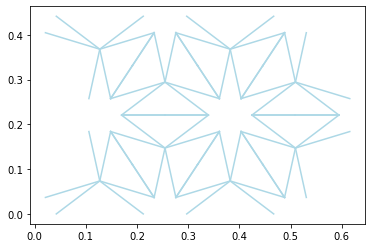

In [17]:
import matplotlib.pyplot as plt
vertices = input_data['vertices']
edge = input_data['edges']
for e in vertices[edge]:
    plt.plot(e[:,0], e[:,1], color='lightblue')

In [18]:
idx = 0 # mesh index
curr_um.getUmbrellaCenterJi(idx, 0), curr_um.getUmbrellaCenterJi(idx, 1)

(0, 2)

In [19]:
idx = 0 # plate index
curr_um.joint(idx).ghost_normal(), curr_um.joint(idx).position, curr_um.joint(idx).jointType()
# what about curr_um.joint(0).pos()  seen at line 940 of file `UmbrellaMesh.hh` and elsewhere

(array([0., 0., 1.]),
 array([0.12737177, 0.07353813, 0.33615618]),
 <JointType.Rigid: 0>)

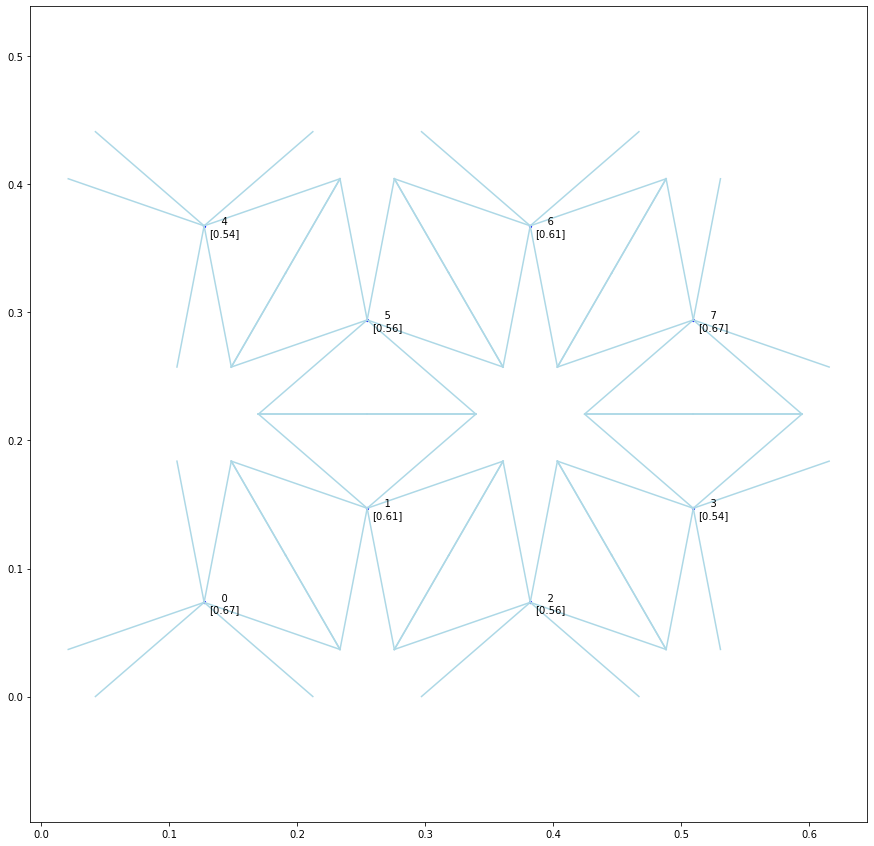

In [20]:
nb_cell = curr_um.numUmbrellas()
center_position = np.zeros([nb_cell, 3])
for i in range(nb_cell):
    top_idx = curr_um.getUmbrellaCenterJi(i, 0)
    # [RQ] what about others second param's values (1 is for bottom, but what about 2,3,4)
    center_position[i] = curr_um.joint(top_idx).position

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
plt.scatter(center_position[:, 0], center_position[:, 1], s=5, color='blue')
for i, ([x,y,z], h) in enumerate(zip(center_position, curr_um.umbrellaHeights)):
    plt.annotate(f'    {i}\n[{h:.2f}]', (x,y), xytext=(5,-10), textcoords='offset points', color='black')
for edge in input_data['vertices'][input_data['edges']][:, :, 0:2]:
    plt.plot(edge[:, 0], edge[:, 1], color="lightblue")
plt.axis('equal')
plt.show()

In [21]:
# for i in range(10000):
#     print(curr_um.getUmbrellaCenterJi(0, i))

In [22]:
?curr_um.deploymentForceType

Type:        property
String form: <property object at 0x7f9bb1180ae0>
Docstring:   Choice of deployment force type between spring and constant

In [23]:
curr_um.targetDeploymentHeightVector, curr_um.targetDeploymentHeight

(array([0., 0., 0., 0., 0., 0., 0., 0.]), 0.0)

In [24]:
uid = 3
idx_top = 0
ij = curr_um.getUmbrellaCenterJi(uid, idx_top)
curr_um.joint(ij).position

# configuration
curr_um.deploymentEnergyWeight, # must be a vector # vs uniformDeplWei is scalar -> 0 for unactivated mesh (stiffness)
# curr_um.targetDeploymentHeightVector # set to 
curr_um.uniformDeploymentEnergyWeight

0.0

In [25]:
target_height_multiplier

5

In [26]:
# The deployment spacing is computed as plate_thickness * target_height_multiplier inside the subsequent deployment call. 
# target_height_multiplier can be a scalar as above or a vector (np.array) of size numUmbrellas

In [42]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False) 

lview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
lview.update(scalarField = rod_colors)
lview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Deploy umbrellaMesh - Go through configuration.py to get some idea about deployment hyper-params. It's okay if you do not understand everything there

In [28]:
# success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, lview, rod_colors, analysis = True, dep_weights=np.logspace(-4, 0, 5))

In [29]:
curr_um.centralJoint(), curr_um.getTargetSurface(), np.logspace(-4, 0, 5)

(17, None, array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]))

In [30]:
# success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, 1, lview, rod_colors, analysis = True, dep_weights=[0])
# line 109 : why +6 in fixedVars
# line 121 : why if(i%1==0) ? : always true


In [39]:
# === targetDeploymentHeightVector ===
# in `configure_umbrella_pre_deployment()`
target_height_multiplier = np.ones(curr_um.numUmbrellas())
target_height_multiplier[0] *= 5
target_height_multiplier[3] *= 0
target_height_multiplier[7] *= 5
target_height_multiplier

array([5., 1., 1., 0., 1., 1., 1., 5.])

In [44]:
# === deploymentEnergyWeight ===
# in `staged_deployment()`
# 0 : not activated
# 1 : activated
weights_per_cell = np.ones(curr_um.numUmbrellas())
# unactivated_cell = [i for i in range(curr_um.numUmbrellas())]
unactivated_cell = [3]
for cell in unactivated_cell:
    weights_per_cell[cell] = 0
# weights_per_cell[0] = 1
# weights_per_cell[1] = 1
dep_weights = np.einsum('i, j -> ij', np.logspace(-4, 0, 5), weights_per_cell)
dep_weights

array([[1.e-04, 1.e-04, 1.e-04, 0.e+00, 1.e-04, 1.e-04, 1.e-04, 1.e-04],
       [1.e-03, 1.e-03, 1.e-03, 0.e+00, 1.e-03, 1.e-03, 1.e-03, 1.e-03],
       [1.e-02, 1.e-02, 1.e-02, 0.e+00, 1.e-02, 1.e-02, 1.e-02, 1.e-02],
       [1.e-01, 1.e-01, 1.e-01, 0.e+00, 1.e-01, 1.e-01, 1.e-01, 1.e-01],
       [1.e+00, 1.e+00, 1.e+00, 0.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00]])

In [45]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um, plate_thickness_scaled, target_height_multiplier, lview, rod_colors, analysis = True, dep_weights=dep_weights)

In [46]:
success

True

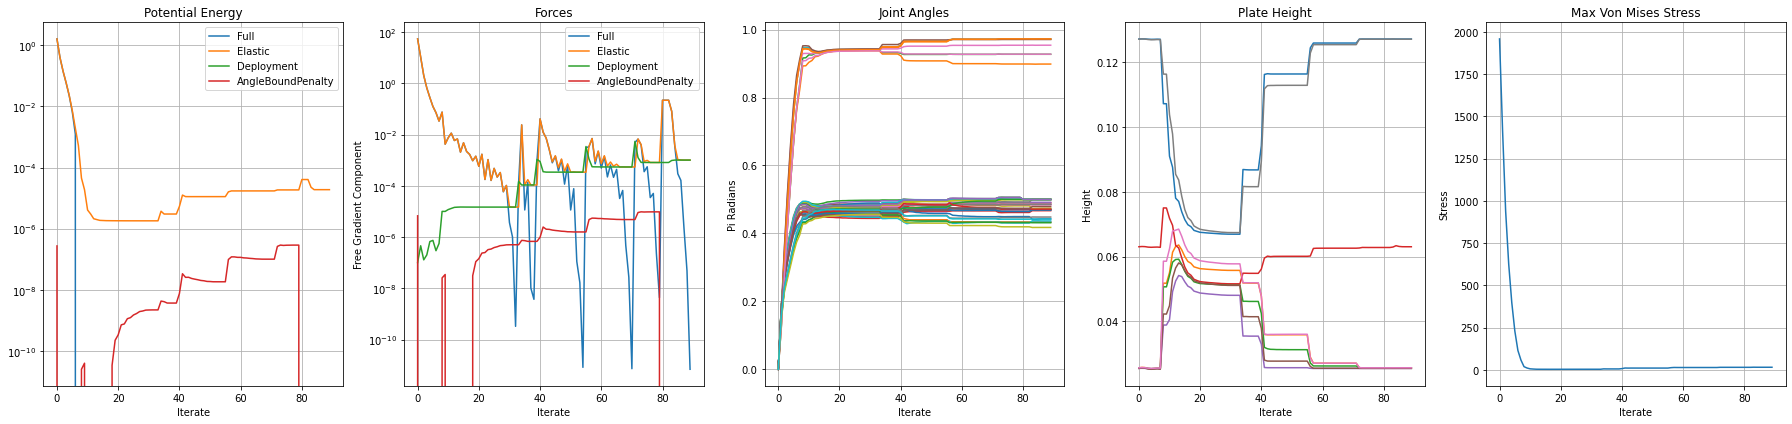

In [47]:
eqays.plot()

## Stress Visualization

In [48]:
sview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
sview.update(scalarField = curr_um.maxVonMisesStresses())
# sview.update(scalarField = curr_um.maxBendingStresses())
# sview.update(scalarField = curr_um.twistingStresses())
sview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [37]:
sigma_vm = np.array(curr_um.maxVonMisesStresses())
sigma_vm.max(), sigma_vm.min()

(11.897276030733805, 1.5543122344752192e-12)

In [38]:
sigma_bending = np.array(curr_um.maxBendingStresses())
sigma_bending.max(), sigma_bending.min()

(11.665462080933597, 0.0)